In [1]:
import weylchamber
from qiskit.converters import circuit_to_dag
from qiskit import transpile
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import ConsolidateBlocks, Collect2qBlocks
from qiskit.quantum_info import Operator
from qiskit.circuit.library import SwapGate, CXGate
from tqdm import tqdm

In [2]:
from slam.utils.circuit_suite import benchmark_lambdas, benchmark_lambdas_no_qv
# benchmark_lambdas[9](6).draw(output="mpl")

In [3]:
from qiskit.transpiler import CouplingMap
map_option = ["a2a", "lattice"][1]
if map_option == "a2a":
    coupling_map = CouplingMap.from_full(16)
elif map_option =="lattice":
    coupling_map = CouplingMap.from_grid(4,4)

In [4]:
coordinate_list = []
for lambda_item in tqdm(benchmark_lambdas[0:1]):
    # load qiskit transpiler with pass for coupling map
    induce_swaps = lambda qc: transpile(qc, coupling_map=coupling_map, optimization_level=3)
    circuit = lambda_item(16)
    circuit = induce_swaps(circuit)
    
    #Proceed
    pm = PassManager()
    pm.append(Collect2qBlocks())
    pm.append(ConsolidateBlocks(force_consolidate=True))
    transp_circuit = pm.run(circuit)
    dag = circuit_to_dag(transp_circuit)
    for gate in dag.collect_2q_runs():
        assert len(gate) == 1 #should be 1 bc of consolidation
        d = Operator(gate[0].op).data
        try:
            coordinate_list.append(weylchamber.c1c2c3(d))
        except ValueError:
            # seems like some SWAPs were getting a rounding error and couldn't be converted to a Weyl chamber coordinate
            # XXX manually add a SWAP - it only happens two or three times total anyway
            coordinate_list.append(weylchamber.c1c2c3(SwapGate().to_matrix()))
coordinate_freq = {i:coordinate_list.count(i) for i in set(coordinate_list)}

100%|██████████| 1/1 [00:02<00:00,  2.18s/it]


In [5]:
# print(coordinate_freq[weylchamber.c1c2c3(SwapGate().to_matrix())])
# print(coordinate_freq[weylchamber.c1c2c3(CXGate().to_matrix())])

106


KeyError: (0.5, 0.0, 0.0)

In [ ]:
679 / (679 + 717)

0.4863896848137536

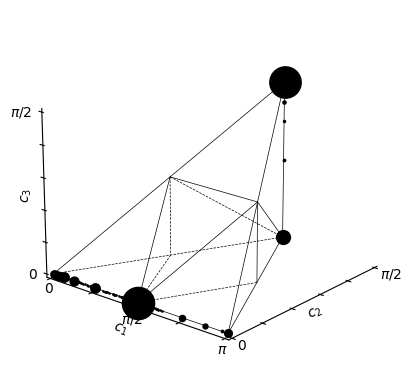

In [ ]:
import matplotlib.pyplot as plt
from slam.utils.visualize import fpath_images
plt.close()
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")

from weylchamber import WeylChamber
w = WeylChamber();

## 
for k, v in coordinate_freq.items():
    ax.scatter3D(*k, s=.75*v, c="k")
##

w.labels = {}
w.render(ax)
# save as pdf and svg
plt.savefig(f"{fpath_images}/shot_chart_{map_option}.pdf", format='pdf')
plt.savefig(f"{fpath_images}/shot_chart_{map_option}.svg", format='svg')
fig.show()